In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from multiclass_classification import *

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [17]:
def load_images_from_folder(root_dir):
    images = []
    labels = []
    # 폴더 이름을 정렬해서 label 인덱스를 일관되게 부여
    label_names = sorted(os.listdir(root_dir))
    label_to_idx = {label: idx for idx, label in enumerate(label_names)}
    
    for label in label_names:
        folder = os.path.join(root_dir, label)
        
        for filename in os.listdir(folder):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                img_path = os.path.join(folder, filename)
                img = Image.open(img_path).convert('L')  # 'L'이면 1채널, RGB이면 convert('RGB')
                img_np = np.array(img)
                # (1, H, W) 모양으로 맞추기 위해 차원 추가 (1-channel 이미지)
                img_np = np.expand_dims(img_np, axis=0)
                images.append(img_np)
                labels.append(label_to_idx[label])
    
    images = np.array(images)  # shape: (N, 1, H, W)
    labels = np.array(labels)
    return images, labels

# 데이터 경로 지정
root_dir = "datasets/iris"
numpy_images, labels = load_images_from_folder(root_dir)

In [24]:
print(len(numpy_images))
print(labels)

256
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [25]:
class Custom_Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X  # 넘파이 배열 (N, 1, H, W)
        self.Y = Y  # 레이블
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # 다시 PyTorch 텐서로 변환
            transforms.RandomRotation(degrees=2),  # ±2도 회전
            transforms.RandomAffine(degrees=0, translate=(0.02, 0.02)),  # 작은 이동
            transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기 및 대비 조절
            transforms.Normalize((0.5), (0.5)),
            transforms.RandomErasing(p=0.1, scale=(0.02, 0.05)),  # 일부 영역을 랜덤하게 지움
            transforms.Resize((224, 224)),  # ResNet 입력 크기에 맞춤
            # transforms.Normalize(mean=[0.5], std=[0.5])  # 데이터 정규화
        ])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index]  # x.shape: (1, H, W)
        y = self.Y[index]

        # 넘파이 배열을 (H, W)로 변환
        if x.shape[0] == 1:
            x = x.squeeze(0)  # (1, H, W) → (H, W)

        # 데이터 증강 적용
        x = self.transform(x) #(1, 46,658)

        return x, y  # PyTorch Tensor 반환

In [32]:
BATCH_SIZE = 32

64
tensor(2)
torch.Size([64, 1, 224, 224])


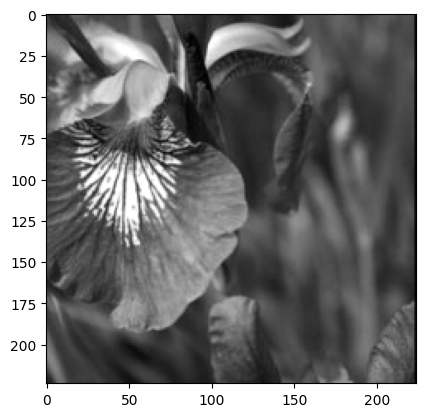

In [28]:
dataset = Custom_Dataset(numpy_images, labels)

dataloader = DataLoader(
    dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
)

data, label = next(iter(dataloader))
print(len(label))
print(label[0])
print(data.size())


plt.imshow(data[0].permute(1, 2, 0), cmap="gray")

In [33]:
train_size = int(0.8 * len(dataset))
val_size = int(0.2 * train_size)
test_size = len(dataset) - train_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size-val_size, val_size, test_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Total dataset size: {len(dataset)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Total dataset size: 421
Train dataset size: 269
validation dataset size: 67
Test dataset size: 85


In [35]:
vgg = models.vgg16(pretrained=True)

num_classes = 3
vgg.classifier[-1] = nn.Linear(vgg.classifier[-1].in_features, num_classes)

/Users/aepeul/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/aepeul/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/aepeul/.cache/torch/hub/checkpoints/vgg16-397923af.pth
 15%|█▍        | 77.6M/528M [00:06<00:40, 11.7MB/s]


KeyboardInterrupt: 

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.0001)

NameError: name 'vgg' is not defined

In [ ]:
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

In [ ]:
train_model(vgg, device, train_loader, val_loader, optimizer, criterion, EPOCHS)